In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from pandasql import sqldf

### Data Loading

In [2]:
df=pd.read_excel("../resources/premiums_with_life_style.xlsx")
print(f"Rows {df.shape[0]} - Cols {df.shape[1]}")
df.head(3)

Rows 10000 - Cols 15


,Age,Gender,Region,Marital_status,Physical_Activity,Stress_Level,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount
0,56,Female,Southeast,Unmarried,Medium,Medium,2,Normal,No Smoking,Self-Employed,25L - 40L,37,High blood pressure,Gold,27944
1,38,Female,Northeast,Married,Low,High,5,Overweight,Occasional,Freelancer,10L - 25L,10,No Disease,Silver,21108
2,18,Female,Southwest,Unmarried,Medium,High,0,Normal,No Smoking,Freelancer,<10L,9,No Disease,Bronze,8459


In [3]:
df.columns = df.columns.str.replace(" ",'_').str.lower()
df.head()

,age,gender,region,marital_status,physical_activity,stress_level,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,56,Female,Southeast,Unmarried,Medium,Medium,2,Normal,No Smoking,Self-Employed,25L - 40L,37,High blood pressure,Gold,27944
1,38,Female,Northeast,Married,Low,High,5,Overweight,Occasional,Freelancer,10L - 25L,10,No Disease,Silver,21108
2,18,Female,Southwest,Unmarried,Medium,High,0,Normal,No Smoking,Freelancer,<10L,9,No Disease,Bronze,8459
3,55,Male,Northeast,Married,High,Medium,3,Overweight,Occasional,Salaried,<10L,9,Thyroid,Silver,21685
4,22,Male,Southeast,Unmarried,Medium,High,2,Normal,Regular,Self-Employed,10L - 25L,13,High blood pressure & Heart disease,Bronze,15984


### Check Null Values

In [4]:
df.isna().sum()

age                       0
gender                    0
region                    0
marital_status            0
physical_activity         0
stress_level              0
number_of_dependants      0
bmi_category              0
smoking_status            9
employment_status         7
income_level             18
income_lakhs              0
medical_history           0
insurance_plan            0
annual_premium_amount     0
dtype: int64

### Check Unique Values Of Missing Columns

In [5]:
df['smoking_status'].unique()

array(['No Smoking', 'Occasional', 'Regular', nan], dtype=object)

In [6]:
df['employment_status'].unique()

array(['Self-Employed', 'Freelancer', 'Salaried', nan], dtype=object)

In [7]:
df['income_level'].unique()

array(['25L - 40L', '10L - 25L', '<10L', '> 40L', nan], dtype=object)

### Visualize Income Level Against Income Lakhs

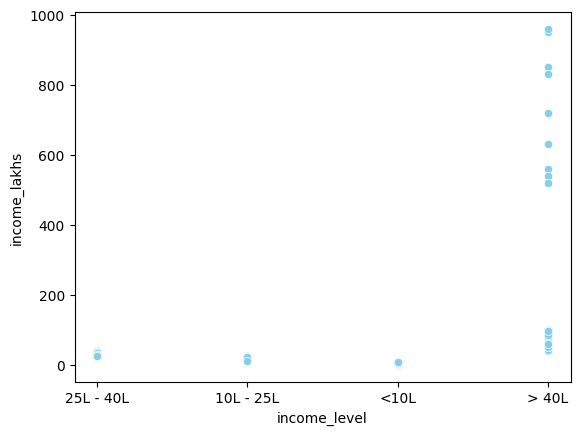

In [8]:
sns.scatterplot(x="income_level", y="income_lakhs", data=df.dropna(), color='skyblue')
plt.show()

### Drop Null Values

In [9]:
df.dropna(inplace=True)

In [10]:
df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
physical_activity        0
stress_level             0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64

### Check duplicate Values

In [11]:
df.duplicated().sum()

np.int64(0)

### Check Outliers

In [12]:
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,9973.000000,9973.000000,9973.000000,9973.000000
mean,41.319362,3.195628,23.382232,19503.816705
std,58.044687,21.679565,32.334811,8898.079736
min,18.000000,0.000000,1.000000,3582.000000
25%,24.000000,0.000000,6.000000,11774.000000
50%,37.000000,2.000000,16.000000,19314.000000
75%,50.000000,3.000000,31.000000,26500.000000
max,1178.000000,456.000000,960.000000,45854.000000


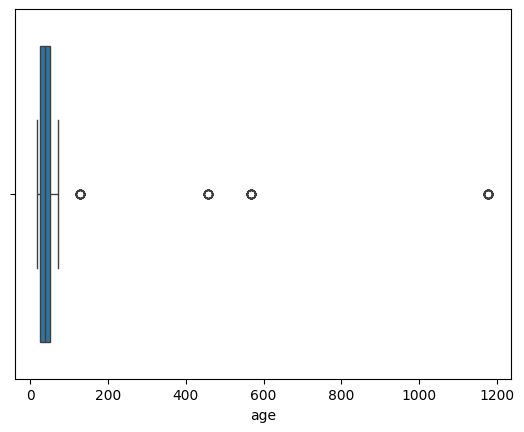

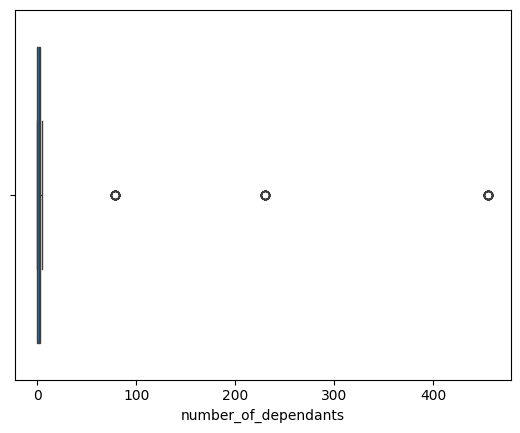

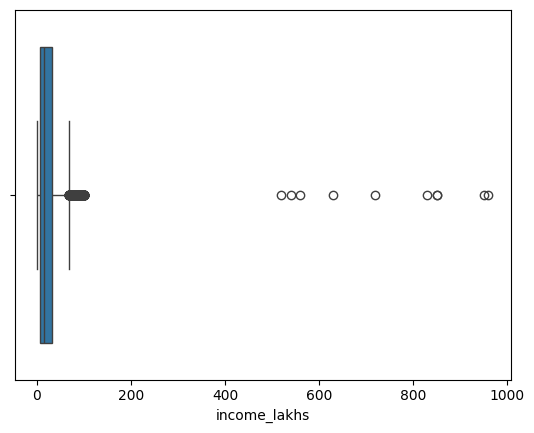

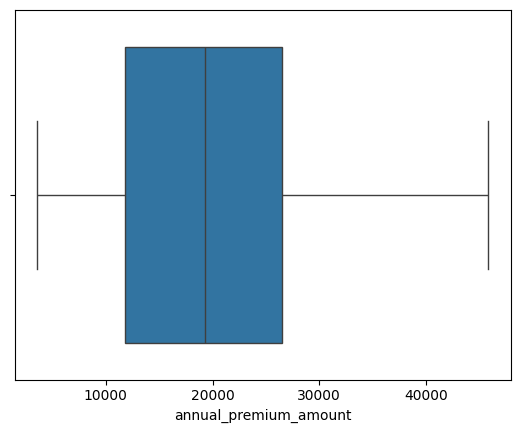

In [13]:
numerical_column=["age","number_of_dependants","income_lakhs","annual_premium_amount"]

for column in numerical_column:
    sns.boxplot(x=df[column])
    plt.show()

#### Age Outliers

In [14]:
df[df.age>100]['age'].unique()

array([ 128, 1178,  567,  456])

In [15]:
df_copy=df[df.age<=100].copy()

#### Number of dependans outliers

In [16]:
df_copy['number_of_dependants'].unique()

array([  2,   5,   0,   3,   1,   4, 456,  78, 230])

In [17]:
df_copy=df_copy[df_copy['number_of_dependants']<=5].copy()

#### Income lakhs outliers

In [18]:
def get_iqr_bounds(col):
    Q1, Q3=col.quantile([0.25, 0.75])
    IQR = Q3-Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound,upper_bound

In [19]:
lower_bound_il,upper_bound_il=get_iqr_bounds(df_copy['income_lakhs'])

In [20]:
lower_bound_il,upper_bound_il

(-31.5, 68.5)

In [21]:
quantile_treshold=df_copy.income_lakhs.quantile(0.999)

In [22]:
quantile_treshold

np.float64(155.86000000068452)

In [23]:
df_copy=df_copy[df_copy.income_lakhs <= quantile_treshold].copy()

In [24]:
df_copy.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,9858.000000,9858.000000,9858.000000,9858.000000
mean,37.764760,1.919963,22.683709,19513.853419
std,13.976268,1.503027,22.453283,8900.593367
min,18.000000,0.000000,1.000000,3582.000000
25%,24.000000,0.000000,6.000000,11777.000000
50%,37.000000,2.000000,16.000000,19331.500000
75%,50.000000,3.000000,31.000000,26505.750000
max,72.000000,5.000000,100.000000,45854.000000
